# [Autoencoders](https://arxiv.org/abs/2201.03898)

## PS6 - Put your answers in these Markdown cells by editing them. You'll find the questions in various Markdown cells

When training CNNs, one of the problems is that we need a lot of labeled data. In the case of image classification, we need to separate images into different classes, which is a manual effort.

However, we might want to use raw (unlabeled) data for training CNN feature extractors, which is called **self-supervised learning**. Instead of labels, we will use training images as both network input and output. The main idea of **autoencoder** is that we will have an **encoder network** that converts input image into some **latent space** (normally it is just a vector of some smaller size), then the **decoder network**, whose goal would be to reconstruct the original image.

Since we are training autoencoder to capture as much of the information from the original image as possible for accurate reconstruction, the network tries to find the best **embedding** of input images to capture the meaning.

![AutoEncoder Diagram](images/autoencoder_schema.jpg)

> Image from [Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)

Let's create simplest autoencoder for MNIST!

In [3]:
pip install -r requirements.txt.

     ---------------------------------------- 0.0/123.4 kB ? eta -:--:--
     -------------------------------------- 123.4/123.4 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
     --- ------------------------------------ 0.7/7.6 MB 21.8 MB/s eta 0:00:01
     ----- ---------------------------------- 1.0/7.6 MB 16.7 MB/s eta 0:00:01
     ---------- ----------------------------- 2.1/7.6 MB 16.6 MB/s eta 0:00:01
     ---------- ----------------------------- 2.1/7.6 MB 16.6 MB/s eta 0:00:01
     ---------------- ----------------------- 3.1/7.6 MB 15.4 MB/s eta 0:00:01
     ---------------- ----------------------- 3.1/7.6 MB 15.4 MB/s eta 0:00:01
     ---------------- ----------------------- 3.1/7.6 MB 15.4 MB/s eta 0:00:01
     ---------------- ----------------------- 3.1/7.6 MB 15.4 MB/s eta 0:00:01
     ---------------- ----------------------- 3.1/7.6 MB 15.4 MB/s eta 0:00:01
     --------------------- ------------------ 4.2/7.6 MB 8.1 MB/s

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

Define training parameters and check if the GPU is available:

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 30

The following function will load the MNIST dataset and apply specified transforms to it. It will also split it into train/test datasets.

In [6]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

Now let's load the dataset and define dataloaders for train and test:

In [80]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

In [8]:

def plotn(n, data, noisy=False, super_res=None):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28) if z[0].shape[1] == 28 else z[0].reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0]
        if super_res is not None:
            _transform = transforms.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
            preprocess = _transform(preprocess)

        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)

        ax[i].imshow(preprocess[0])
    plt.show()

In [9]:
def noisify(shapes):
    return np.random.normal(loc=0.5, scale=0.3, size=shapes)

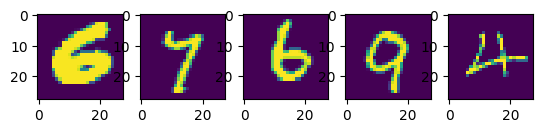

In [10]:
plotn(5, train_dataset)

## Use the Pytorch documentation and videos https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html to answer these questions

### What are the different "types" of layers being used in the Encoder below and say in words what they do?
### What are the arguments to Conv2d 
### What does maxpool do?  
### What does ReLU do? 

The encoder below is using convolutional layers, max pooling layers, and ReLU activation functions. 

The convolutional layers are used to extract features from the input image. The arguments to Conv2D are the size of the filter, the number of input and output channels, the padding, and the stride. The padding is used to add random padding to the input image, otherwise convolution would shrink the input image. The stride is used to control the stride of the convolution (how far the filter moves per step). The numbr of filters is important as a hyperparameter to control the number of features extracted from the input image. The size of the filter is also important as a hyperparameter to control the size of the features extracted from the input image.

The max pooling layers are used to reduce the size of the image. This makes the output smaller and translationally invariant. This allows us to extract feautures without worrying about position and allows us to work with a resonable number of parameters.


The ReLU activation function is used to introduce non-linearity into the model.


In [21]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()
        # Make latent space 2 dimensional using a fully connected layer
        self.fc1 = nn.Linear(8 * 3 * 3, 2)
        # Apply a relu activation function
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        return encoded

### What does upsample do? 

Upsample does the opposite of maxpool, it increases the size of the image so that it can be concatenated with the output of the encoder.

In [22]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

In [23]:
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        if not super_resolution:
            self.encoder = Encoder()
        else:
            self.encoder = SuperResolutionEncoder()
        self.decoder = Decoder()

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

### What does the optimizer do in the code below? 
### Which optimizer is being used?

The optimizer performs stochastic gradient descent to minimize the binary cross entropy loss. The optimizer used is Adam which is a variant of SGD. It tends to converge faster.

In [25]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device, noisy=None, super_res=None):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            shapes = list(imgs.shape)

            if super_res is not None:
                shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                _transform = transforms.Resize((shapes[2], shapes[3]))
                imgs_transformed = _transform(imgs)
                imgs_transformed = imgs_transformed.to(device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            if noisy is not None:
                noisy_tensor = noisy[0]
            else:
                noisy_tensor = torch.zeros(tuple(shapes)).to(device)

            if super_res is None:
                imgs_noisy = imgs + noisy_tensor
            else:
                imgs_noisy = imgs_transformed + noisy_tensor

            imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

            preds = model(imgs_noisy)
            loss = loss_fn(preds, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                shapes = list(imgs.shape)

                if super_res is not None:
                    shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                    _transform = transforms.Resize((shapes[2], shapes[3]))
                    imgs_transformed = _transform(imgs)
                    imgs_transformed = imgs_transformed.to(device)


                imgs = imgs.to(device)
                labels = labels.to(device)

                if noisy is not None:
                    test_noisy_tensor = noisy[1]
                else:
                    test_noisy_tensor = torch.zeros(tuple(shapes)).to(device)

                if super_res is None:
                    imgs_noisy = imgs + test_noisy_tensor
                else:
                    imgs_noisy = imgs_transformed + test_noisy_tensor

                imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

                preds = model(imgs_noisy)
                loss = loss_fn(preds, imgs)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [17]:
# Create two noise tensors for train and test
noisy = [torch.randn(1, 28, 28) * 0.1, torch.randn(1, 28, 28) * 0.1]


In [18]:
train(dataloaders, model, loss_fn, optimizer, epochs, device,noisy=noisy)

100%|██████████| 30/30 [17:08<00:00, 34.30s/it, train loss:=0.0991, test loss:=0.102]


In [26]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [16:24<00:00, 32.83s/it, train loss:=0.102, test loss:=0.102]


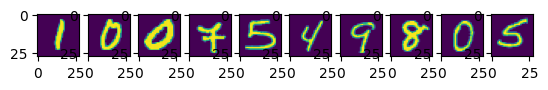

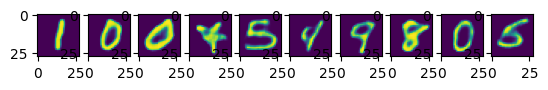

In [28]:
model.eval()
predictions = []
plots = 10
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

> **Task 1**: Try to train autoencoder with very small latent vector size, eg. 2, and plot the dots corresponding to different digits. *Hint: Use fully-connected dense layer after the convoluitonal part to reduce the vector size to the required value.*

> **Task 2**: Starting from different digits, obtain their latent space representations, and see what effect adding some noise to the latent space has on the resulting digits.

Reducing the latent vector to size 2 still allowed for a good representation of the digits, although the representation was not as accurate as the baseline. This makes sense because you are trying to approximate the image with a 2 dimensional vector, which is not enough information to perfectly represent the image.

Adding noise to the latent space of the image has had the result of adding more noise to the image. This makes sense because the decoder is being given a less accurate representation of the image.

## Denoising

Autoencoders can be effectively used to remove noise from images. In order to train denoiser, we will start with noise-free images, and add artificial noise to them. Then, we will feed autoencoder with noisy images as input, and noise-free images as output.

Let's see how this works for MNIST:

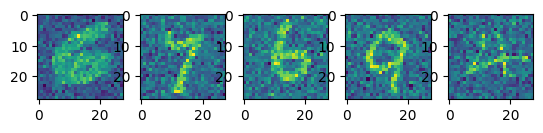

In [27]:
plotn(5, train_dataset, noisy=True)

In [29]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [30]:
noisy_tensor = torch.FloatTensor(noisify([256, 1, 28, 28])).to(device)
test_noisy_tensor = torch.FloatTensor(noisify([1, 1, 28, 28])).to(device)
noisy_tensors = (noisy_tensor, test_noisy_tensor)

In [32]:
train(dataloaders, model, loss_fn, optimizer, 50, device, noisy=noisy_tensors)

100%|██████████| 50/50 [1:00:42<00:00, 72.86s/it, train loss:=0.115, test loss:=0.114] 


In [33]:
# load FashionMNIST dataset
from torchvision import datasets, transforms
fashionMNIST = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



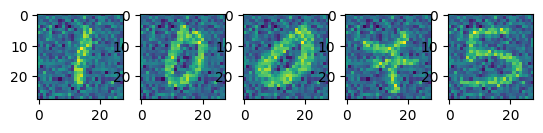

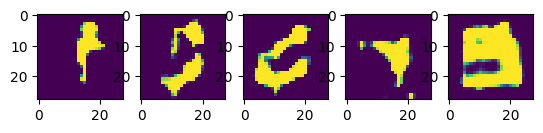

In [34]:
model.eval()
predictions = []
noise = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    shapes = data[0].shape
    noisy_data = data[0] + test_noisy_tensor[0].detach().cpu()
    noise.append(noisy_data)
    predictions.append(model(noisy_data.to(device).unsqueeze(0)).detach().cpu())
plotn(plots, noise)
plotn(plots, predictions)

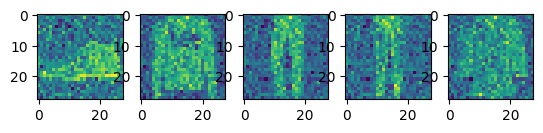

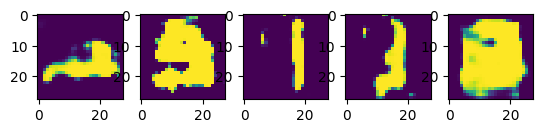

In [35]:
predictions = []
noise = []
plots = 5
for i, data in enumerate(fashionMNIST):
    if i == plots:
        break
    shapes = data[0].shape
    noisy_data = data[0] + test_noisy_tensor[0].detach().cpu()
    noise.append(noisy_data)
    predictions.append(model(noisy_data.to(device).unsqueeze(0)).detach().cpu())
plotn(plots, noise)
plotn(plots, predictions)

> **Exercise:** See how denoiser trained on MNIST digits works for different images. As an example, you can take [Fashion MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) dataset, which has the same image size. Note that denoiser works well only on the same image type that it was trained on (i.e. for the same probability distribution of input data).

The denoiser does not work well at all on the Fashion MNIST dataset. This data has a different probability distribution so the denoiser can't generalize well to it.

## Super-Resolution

Similarly to denoiser, we can train autoencoders to increase the resolution of the image. To train super-resolution network, we will start with high-resolution images, and automatically downscale them to produce network inputs. We will then feed autoencoder with small images as inputs and high-resolution images as outputs.

For that let's downscale image to 14x14 at train.

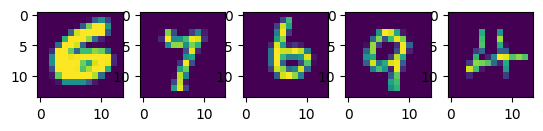

In [36]:
super_res_koeff = 2.0
plotn(5, train_dataset, super_res=super_res_koeff)

In [37]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        encoded = self.maxpool2(self.relu(self.conv2(hidden1)))
        return encoded

In [38]:
model = AutoEncoder(super_resolution=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [39]:
train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=2.0)

100%|██████████| 30/30 [10:28<00:00, 20.96s/it, train loss:=0.105, test loss:=0.105]


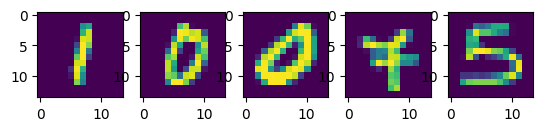

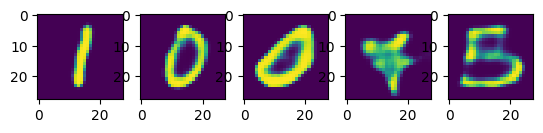

In [40]:
model.eval()
predictions = []
plots = 5
shapes = test_dataset[0][0].shape

for i, data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
    predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)

In [42]:
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_data, test = torch.utils.data.random_split(cifar10, [40000, 10000])
train_dataset = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_dataset = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)
dataloaders = {'train': train_dataset, 'test': test_dataset}


# Train super resolution model for CIFAR10 dataset with 2x upscale
model = AutoEncoder(super_resolution=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=2.0)

model.eval()
predictions = []
plots = 5
shapes = test_dataset[0][0].shape

for i, data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
    predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)


Files already downloaded and verified


TypeError: 'Subset' object is not callable

In [81]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

In [82]:
# train with 4x upscale
# get noise 
train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=4.0, noise=True)

model.eval()
predictions = []    
plots = 5
shapes = test_dataset[0][0].shape

for i, data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
    predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)

TypeError: 'Subset' object is not callable

> **Exercise**: Try to train super-resolution network on [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) for 2x and 4x upscaling. Use noise as input to 4x upscaling model and observe the result.

# [Variational Auto-Encoders (VAE)](https://arxiv.org/abs/1906.02691)

Traditional autoencoders reduce the dimension of the input data somehow, figuring out the important features of input images. However, latent vectors often do not make much sense. In other words, taking MNIST dataset as an example, figuring out which digits correspond to different latent vectors is not an easy task, because close latent vectors would not necessarily correspond to the same digits. 

On the other hand, to train *generative* models it is better to have some understanding of the latent space. This idea leads us to **variational auto-encoder** (VAE).

VAE is the autoencoder that learns to predict *statistical distribution* of the latent parameters, so-called **latent distribution**. For example, we can assume that latent vectors would be distributed as $N(\mathrm{z\_mean},e^{\mathrm{z\_log}})$, where $\mathrm{z\_mean}, \mathrm{z\_log} \in\mathbb{R}^d$. Encoder in VAE learns to predict those parameters, and then decoder takes a random vector from this distribution to reconstruct the object.

To summarize:

 * From input vector, we predict `z_mean` and `z_log` (instead of predicting the standard deviation itself, we predict it's logarithm)
 * We sample a vector `sample(z_val in code)` from the distribution $N(\mathrm{z\_mean},e^{\mathrm{z\_log\_sigma}})$
 * Decoder tries to decode the original image using `sample` as an input vector

 <img src="images/vae.png" width="50%">

 > Image from [this blog post](https://ijdykeman.github.io/ml/2016/12/21/cvae.html) by Isaak Dykeman

In [83]:
class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.FloatTensor(np.random.normal(size=(bs, self.latent_dim))).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [61]:
class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded

In [62]:
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None

    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded
    
    def get_zvals(self):
        return self.z_vals

Variational auto-encoders use complex loss function that consists of two parts:
* **Reconstruction loss** is the loss function that shows how close reconstructed image is to the target (can be MSE). It is the same loss function as in normal autoencoders.
* **KL loss**, which ensures that latent variable distributions stays close to normal distribution. It is based on the notion of [Kullback-Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) - a metric to estimate how similar two statistical distributions are.

In [63]:
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [64]:
model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [65]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            z_vals = model.get_zvals()
            loss = vae_loss(preds, imgs, z_vals)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                z_vals = model.get_zvals()
                loss = vae_loss(preds, imgs, z_vals)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [84]:
train_vae(dataloaders, model, optimizer, epochs, device)

100%|██████████| 30/30 [05:31<00:00, 11.05s/it, train loss:=34.6, test loss:=35.4]


  0%|          | 0/30 [07:37<?, ?it/s]


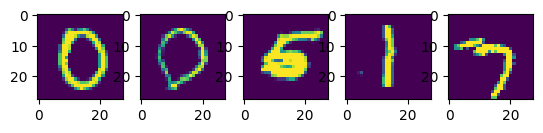

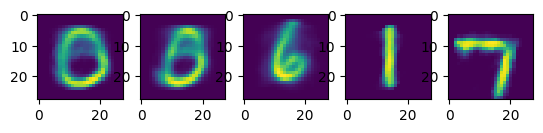

In [85]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

> **Task**: In our sample, we have trained fully-connected VAE. Now take the CNN from traditional auto-encoder above and create CNN-based VAE.

In [88]:
# Using the CNN from the autoencoder create a CNN-based variational autoencoder
# Train the model and plot the results

class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.FloatTensor(np.random.normal(size=(bs, self.latent_dim))).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val
    
class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded
    
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None

    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded
    
    def get_zvals(self):
        return self.z_vals
    
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

100%|██████████| 30/30 [05:30<00:00, 11.01s/it, train loss:=38.2, test loss:=38.4]


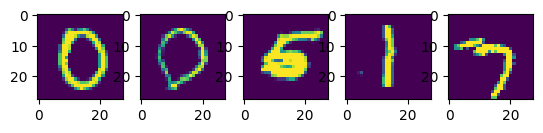

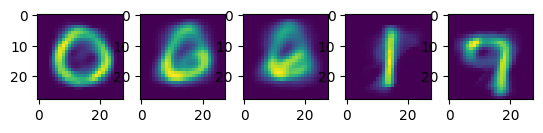

In [89]:
# Train the model and plot the results
train_vae(dataloaders, model, optimizer, epochs, device)

model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)



# [Adversarial Auto-Encoders (AAE)](https://arxiv.org/abs/1511.05644)

Adversarial Auto-Encoders is a **combination** of Generative Adversarial Networks and Variational Auto-Encoders. 

Encoder will be the generator, discriminator will learn to distinguish the real images encoder output from generated ones. Encoder output is a distribution, from this output decoder will try decode image.

In this approach we have **three loss functions**: generator loss, discriminator loss from GAN's and reconstruction loss from VAE.

 <img src="images/aae.png" width="50%">

 > Image from [this blog post](https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/) by Felipe Ducau

In [70]:
class AAEEncoder(nn.Module):
    def __init__(self, input_dim, inter_dim, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, latent_dim)
        self.relu = nn.ReLU()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        encoded = self.linear4(hidden3)
        return encoded

In [71]:
class AAEDecoder(nn.Module):
    def __init__(self, latent_dim, inter_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        decoded = self.sigmoid(self.linear4(hidden3))
        return decoded

In [72]:
class AAEDiscriminator(nn.Module):
    def __init__(self, latent_dim, inter_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.inter_dim = inter_dim
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, inter_dim)
        self.linear5 = nn.Linear(inter_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        hidden4 = self.relu(self.linear4(hidden3))
        decoded = self.sigmoid(self.linear4(hidden4))
        return decoded
    
    def get_dims(self):
        return self.latent_dim, self.inter_dim
        

In [73]:
input_dims = 784
inter_dims = 1000
latent_dims = 150

In [74]:
aae_encoder = AAEEncoder(input_dims, inter_dims, latent_dims).to(device)
aae_decoder = AAEDecoder(latent_dims, inter_dims, input_dims).to(device)
aae_discriminator = AAEDiscriminator(latent_dims, int(inter_dims / 2)).to(device)

In [75]:
lr = 1e-4
regularization_lr = 5e-5

In [76]:
optim_encoder = optim.Adam(aae_encoder.parameters(), lr=lr)
optim_encoder_regularization = optim.Adam(aae_encoder.parameters(), lr=regularization_lr)
optim_decoder = optim.Adam(aae_decoder.parameters(), lr=lr)
optim_discriminator = optim.Adam(aae_discriminator.parameters(), lr=regularization_lr)

In [77]:
def train_aae(dataloaders, models, optimizers, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    
    enc, dec, disc = models[0], models[1], models[2]
    optim_enc, optim_enc_reg, optim_dec, optim_disc = optimizers[0], optimizers[1], optimizers[2], optimizers[3]
    
    eps = 1e-9

    for epoch in tqdm_iter:
        enc.train()
        dec.train()
        disc.train()

        train_reconst_loss = 0.0
        train_disc_loss = 0.0
        train_enc_loss = 0.0
        
        test_reconst_loss = 0.0
        test_disc_loss = 0.0
        test_enc_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.view(imgs.shape[0], -1).to(device)
            labels = labels.to(device)
            
            enc.zero_grad()
            dec.zero_grad()
            disc.zero_grad()
             
            encoded = enc(imgs)
            decoded = dec(encoded)
            
            reconstruction_loss = F.binary_cross_entropy(decoded, imgs)
            reconstruction_loss.backward()
            
            optim_enc.step()
            optim_dec.step()
            enc.eval()

            latent_dim, disc_inter_dim = disc.get_dims()
            real = torch.randn(imgs.shape[0], latent_dim).to(device)
            
            disc_real = disc(real)
            disc_fake = disc(enc(imgs))
            
            disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))
            disc_loss.backward()
            
            optim_dec.step()
            enc.train()
            
            disc_fake = disc(enc(imgs))
            enc_loss = -torch.mean(torch.log(disc_fake + eps))
            enc_loss.backward()
            
            optim_enc_reg.step()

            train_reconst_loss += reconstruction_loss.item()
            train_disc_loss += disc_loss.item()
            train_enc_loss += enc_loss.item()

        enc.eval()
        dec.eval()
        disc.eval()

        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.view(imgs.shape[0], -1).to(device)
                labels = labels.to(device)

                encoded = enc(imgs)
                decoded = dec(encoded)

                reconstruction_loss = F.binary_cross_entropy(decoded, imgs)


                latent_dim, disc_inter_dim = disc.get_dims()
                real = torch.randn(imgs.shape[0], latent_dim).to(device)

                disc_real = disc(real)
                disc_fake = disc(enc(imgs))
                disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))

                disc_fake = disc(enc(imgs))
                enc_loss = -torch.mean(torch.log(disc_fake + eps))

                test_reconst_loss += reconstruction_loss.item()
                test_disc_loss += disc_loss.item()
                test_enc_loss += enc_loss.item()

        train_reconst_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)
        train_enc_loss /= len(train_dataloader)
        
        test_reconst_loss /= len(test_dataloader)
        test_disc_loss /= len(test_dataloader)
        test_enc_loss /= len(test_dataloader)

        tqdm_dct = {'train reconst loss:': train_reconst_loss, 'train disc loss:': train_disc_loss, 'train enc loss': train_enc_loss, \
                        'test reconst loss:': test_reconst_loss, 'test disc loss:': test_disc_loss, 'test enc loss': test_enc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [78]:
models = (aae_encoder, aae_decoder, aae_discriminator)
optimizers = (optim_encoder, optim_encoder_regularization, optim_decoder, optim_discriminator)

In [90]:
train_aae(dataloaders, models, optimizers, epochs, device)

100%|██████████| 30/30 [50:54<00:00, 101.83s/it, train reconst loss:=0.0915, train disc loss:=1.39, train enc loss=0.692, test reconst loss:=0.094, test disc loss:=1.39, test enc loss=0.692] 


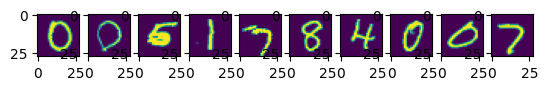

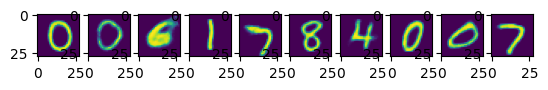

In [91]:
aae_encoder.eval()
aae_decoder.eval()
predictions = []
plots = 10
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    pred = aae_decoder(aae_encoder(data[0].to(device).unsqueeze(0).view(1, 784)))
    predictions.append(pred.view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

## Additional Materials

* [Blog post on NeuroHive](https://neurohive.io/ru/osnovy-data-science/variacionnyj-avtojenkoder-vae/)
* [Variational Autoencoders Explained](https://kvfrans.com/variational-autoencoders-explained/)